In [35]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.stats import kde

In [2]:
df = pd.read_csv('../options-df-sigma.csv')
df = df.dropna(axis=0)
df = df.drop(columns=['date', 'exdate', 'impl_volatility', 'volume', 'open_interest'])
df.strike_price = df.strike_price / 1000
call_df = df[df.cp_flag == 'C'].drop(['cp_flag'], axis=1)
put_df = df[df.cp_flag == 'P'].drop(['cp_flag'], axis=1)

In [3]:
call_X_train, call_X_test, call_y_train, call_y_test = train_test_split(call_df.drop(['best_bid', 'best_offer'], axis=1),
                                                                        call_df[['best_bid', 'best_offer']],
                                                                        test_size=0.01, random_state=42)
put_X_train, put_X_test, put_y_train, put_y_test = train_test_split(put_df.drop(['best_bid', 'best_offer'], axis=1),
                                                                    put_df[['best_bid', 'best_offer']],
                                                                    test_size=0.01, random_state=42)

In [4]:
from keras.models import load_model
call = load_model('mlp2-call60.h5')
put = load_model('mlp2-put60.h5')

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [5]:
call_y_pred = call.predict(call_X_test)
put_y_pred = put.predict(put_X_test)

In [6]:
def error_metrics(actual, predicted):
    diff = actual - predicted
    mse = np.mean(np.square(diff))
    rel = diff / actual
    bias = 100 * np.median(rel)
    aape = 100 * np.mean(np.abs(rel))
    mape = 100 * np.median(np.abs(rel))
    pe5 = 100 * sum(np.abs(rel) < 0.05) / rel.shape[0]
    pe10 = 100 * sum(np.abs(rel) < 0.10) / rel.shape[0]
    pe20 = 100 * sum(np.abs(rel) < 0.20) / rel.shape[0]
    return [mse, bias, aape, mape, pe5, pe10, pe20]

In [7]:
call_errors = error_metrics(np.mean(call_y_test, axis=1), np.mean(call_y_pred, axis=1))
put_errors = error_metrics(np.mean(put_y_test, axis=1), np.mean(put_y_pred, axis=1))

In [11]:
def matrix(actual, predicted, q):
    rel = (actual - predicted) / actual
    def segregate(x, q):
        up = x > q
        low = x < -q
        mid = ~(up | low)
        return (up, mid, low)
    bid = rel.iloc[:,0]
    ask = rel.iloc[:,1]
    x = segregate(bid, q)
    y = segregate(ask, q)
    return np.array([[sum(x[i] & y[j]) for i in range(3)] for j in range(3)]) / rel.shape[0]

In [12]:
matrix(call_y_test, call_y_pred, 0.01) 

array([[0.24243553, 0.092753  , 0.01503096],
       [0.034922  , 0.32105903, 0.03168848],
       [0.01487419, 0.04797366, 0.19926315]])

In [15]:
matrix(put_y_test, put_y_pred, 0.01) 

array([[0.44923251, 0.12136395, 0.0139688 ],
       [0.03360303, 0.08175911, 0.01687233],
       [0.02919462, 0.02184728, 0.23215835]])

In [28]:
matrix(put_y_test, put_y_pred, 0.05)

array([[0.36014376, 0.10932493, 0.00152258],
       [0.02505179, 0.29755856, 0.01448223],
       [0.0123754 , 0.01977586, 0.15976489]])

In [29]:
matrix(call_y_test, call_y_pred, 0.05)

array([[0.17212119, 0.07439053, 0.00123462],
       [0.01265972, 0.60496198, 0.00881869],
       [0.00399781, 0.01732382, 0.10449165]])

In [72]:
def error_scatter(actual, predicted):
    temp = 100 * (actual - predicted) / actual
    plt.scatter(temp.iloc[:,0], temp.iloc[:,1], s=1)
    plt.xlim(-100, 100)
    plt.ylim(-100, 100)
    plt.xlabel('Bid Error %')
    plt.ylabel('Ask Error %')

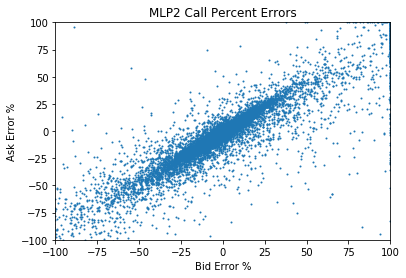

In [79]:
error_scatter(call_y_test, call_y_pred)
plt.title('MLP2 Call Percent Errors')
plt.savefig('mlp2-call-scatter.png')

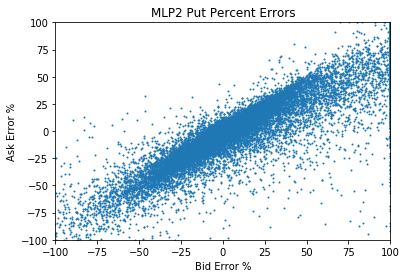

In [80]:
error_scatter(put_y_test, put_y_pred)
plt.title('MLP2 Put Percent Errors')
plt.savefig('mlp2-put-scatter.png')

In [75]:
def kde_scatter(actual, predicted):
    rel = 100 * (actual - predicted) / actual
    rel = rel.replace([np.inf, -np.inf], np.nan)
    rel = rel.dropna()
    temp = rel[np.linalg.norm(rel, ord=np.inf, axis=1) < 100]
    k = kde.gaussian_kde(temp.T)
    plt.scatter(temp.iloc[:,0], temp.iloc[:,1], c=k(temp.T), s=1)
    plt.xlim(-10, 10)
    plt.ylim(-10, 10)
    plt.xlabel('Bid Error %')
    plt.ylabel('Ask Error %')

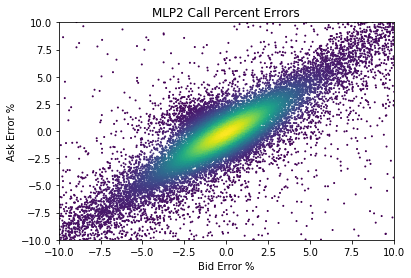

In [81]:
kde_scatter(call_y_test, call_y_pred)
plt.title('MLP2 Call Percent Errors')
plt.savefig('mlp2-call-kde.png')

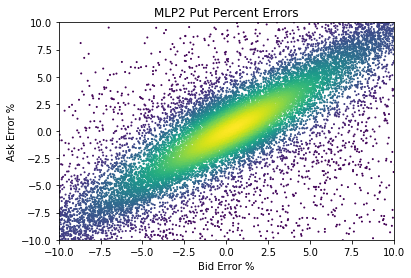

In [82]:
kde_scatter(put_y_test, put_y_pred)
plt.title('MLP2 Put Percent Errors')
plt.savefig('mlp2-put-kde.png')

In [83]:
call_train_pred = call.predict(call_X_train)
put_train_pred = put.predict(put_X_train)

In [86]:
call_errors.insert(0, np.mean(np.square(np.diff(call_y_train, axis=1) - np.diff(call_train_pred, axis=1))))

In [87]:
put_errors.insert(0, np.mean(np.square(np.diff(put_y_train, axis=1) - np.diff(put_train_pred, axis=1))))

In [89]:
for line in (call_errors, put_errors):
    print('& {:.2f} & {:.2f} & {:.2f} & {:.2f} & {:.2f} & {:.2f} & {:.2f} & {:.2f} \\\\'.format(*line))

& 7.70 & 15.21 & 0.09 & 23.45 & 1.73 & 63.03 & 70.10 & 75.54 \\
& 2.03 & 8.84 & 3.85 & 39.59 & 14.32 & 33.74 & 44.25 & 55.01 \\
